This Colab notebook demonstrates transfer learning with a pretrained ConvNet:

0.   Data pipeline
1.   Baseline model: train a simple CNN from scratch
2.   Transfer learning: pretraiend ConvNet as a feature extractor
3.   Transfer learning: fine-tune a pretrained ConvNet
4.   Test accuracy & visualize predictions



In [1]:
# Enable TensorFlow 2.0
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [2]:
# Import Tensorflow
import tensorflow as tf
tf.__version__

'2.1.0'

In [0]:
# Import TensorFlow datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Import Keras 
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Import Numpy
import numpy as np
import matplotlib.pyplot as plt

## Data pipeline

#### Load the tf_flowers dataset
tf_flowers is one of the TensorFlow 2.0 datasets with 3670 samples.

In [4]:
# Load train and validation datasets
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name='tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], # train, validation, test split of 8:1:1
    with_info=True,
    as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/tf_flowers/3.0.0.incomplete3347B6/tf_flowers-train.tfrecord
Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.0. Subsequent calls will reuse this data.


In [5]:
print("Total number of samples:",  metadata.splits['train'].num_examples)

Total number of samples: 3670


In [6]:
num_classes = metadata.features['label'].num_classes
num_train =  len(list(raw_train))
num_validation = len(list(raw_validation))
num_test = len(list(raw_test))

print("Number of classes:", num_classes)
print("Number of training samples:", num_train)
print("Number of validation samples:",  num_validation)
print("Number of test samples:", num_test)

Number of classes: 5
Number of training samples: 2936
Number of validation samples: 367
Number of test samples: 367


In [7]:
# Inspect datasets before data preprocessing
print(raw_train)
print(raw_validation)
print(raw_test)

<DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


In [8]:
# Get labels / class names
class_names = np.array(metadata.features['label'].names)
print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


### Visualize the data
Let's take a look a few of the flower images

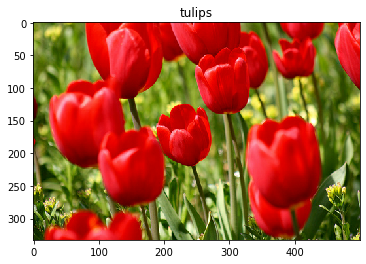

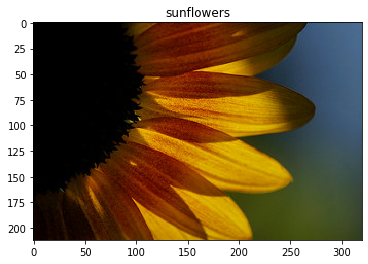

In [9]:
label_names = metadata.features['label'].int2str

for image, label in raw_train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(label_names(label))

### Image preprocessing

Resize, normalize, augment, shuffle and batch the data.

#### Resize and normalize dataset

In [0]:
IMG_SIZE = 224 
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  image = image/255.0
  return image, label

In [0]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [0]:
def augment_data(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_contrast(image, lower=0.0, upper=1.0)
  image = tf.stack(image, axis=0)
  image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
  return image, label

In [0]:
train = train.map(augment_data)

#### Shuffle and batch dataset

In [0]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()
validation_batches = validation.batch(BATCH_SIZE).repeat()
test_batches = test.batch(BATCH_SIZE)

In [15]:
# Inspect datasets after data preprocessing
print(train_batches)
print(validation_batches)
print(test_batches)

<DatasetV1Adapter shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>
<DatasetV1Adapter shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>
<DatasetV1Adapter shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>


In [16]:
# Inspect a batch of data
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([32, 224, 224, 3])

## Training

In [0]:
# Set training parameters
NUM_EPOCHS = 10
steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps = round(num_validation)//BATCH_SIZE

In [0]:
# Display training curves
def display_training_curves(history, title):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(NUM_EPOCHS)

  plt.plot(epochs_range, acc, label='Train accuracy')
  plt.plot(epochs_range, val_acc, label='Val accuracy')
  plt.title(title)
  plt.legend(loc='upper left')
  plt.figure()

  plt.show()

### Baseline  - train from scratch
Train a very simple CNN model and use the accuracy metrics as baseline to compare with transfer learning results.


#### Create model

In [0]:
def build_model_from_scratch():

  model = Sequential([
   # Must define the input shape in the first layer of the neural network
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=IMG_SHAPE),
    MaxPooling2D(pool_size=2),

    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
  ])

  return model

In [0]:
simple_cnn_model = build_model_from_scratch()

In [21]:
simple_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                12845120  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 3

#### Compile and train the model

In [0]:
def train_model(model):
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(train_batches,
              epochs=NUM_EPOCHS, 
              validation_data=validation_batches,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps)
    
    return history

In [23]:
%%time
history = train_model(simple_cnn_model)

Train for 91 steps, validate for 11 steps
Epoch 1/10
91/91 [==============================] - 17s 182ms/step - loss: 1.7985 - accuracy: 0.3451 - val_loss: 1.2172 - val_accuracy: 0.4659
Epoch 2/10
91/91 [==============================] - 11s 116ms/step - loss: 1.2802 - accuracy: 0.4418 - val_loss: 1.1406 - val_accuracy: 0.5426
Epoch 3/10
91/91 [==============================] - 11s 116ms/step - loss: 1.1975 - accuracy: 0.4917 - val_loss: 1.0945 - val_accuracy: 0.5653
Epoch 4/10
91/91 [==============================] - 11s 117ms/step - loss: 1.1756 - accuracy: 0.5141 - val_loss: 1.0774 - val_accuracy: 0.5824
Epoch 5/10
91/91 [==============================] - 11s 117ms/step - loss: 1.1272 - accuracy: 0.5296 - val_loss: 1.0531 - val_accuracy: 0.5852
Epoch 6/10
91/91 [==============================] - 11s 120ms/step - loss: 1.0738 - accuracy: 0.5640 - val_loss: 1.1865 - val_accuracy: 0.5881
Epoch 7/10
91/91 [==============================] - 11s 117ms/step - loss: 1.0537 - accuracy: 0.5651

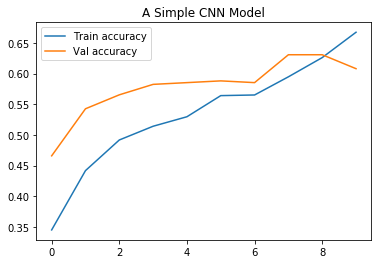

<Figure size 432x288 with 0 Axes>

In [24]:
# Display training curve 
display_training_curves(history, "A Simple CNN Model")

### Transfer learning 

Now let's see how transfer learning can help achieve better results.

#### Feature extractor

Use MobileNetV2 as a feature extractor and add a classifier on top of it.

##### Create base model

In [25]:
# Create base model from tf.keras pre-trained model MobileNetV2
base_model = MobileNetV2(input_shape=IMG_SHAPE,
                         weights="imagenet", 
                         include_top=False)

9412608/9406464 [==============================] - 1s 0us/step


##### Freeze all layers of the base model

In [0]:
base_model.trainable = False

##### Add a classifier head
Create a new model by adding a classifier on top of the base model.

In [0]:
def build_mobilenetv2_model(base_model):
  model = Sequential([
      base_model,
      Conv2D(32, 3, activation='relu'),
      GlobalAveragePooling2D(),
      Dense(num_classes, activation='softmax')]
  )

  return model

In [0]:
model = build_mobilenetv2_model(base_model)

##### Compile the model

In [0]:
model.compile(optimizer= Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 165       
Total params: 2,626,821
Trainable params: 368,837
Non-trainable params: 2,257,984
_________________________________________________________________


##### Train the model

In [31]:
%%time
history = model.fit(train_batches,
                    epochs=NUM_EPOCHS,
                    validation_data=validation_batches,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)

Train for 91 steps, validate for 11 steps
Epoch 1/10
91/91 [==============================] - 15s 170ms/step - loss: 1.0006 - accuracy: 0.6006 - val_loss: 1.4935 - val_accuracy: 0.6051
Epoch 2/10
91/91 [==============================] - 9s 97ms/step - loss: 0.6119 - accuracy: 0.7683 - val_loss: 0.9043 - val_accuracy: 0.7528
Epoch 3/10
91/91 [==============================] - 10s 115ms/step - loss: 0.5092 - accuracy: 0.8161 - val_loss: 0.9795 - val_accuracy: 0.7273
Epoch 4/10
91/91 [==============================] - 11s 117ms/step - loss: 0.4337 - accuracy: 0.8430 - val_loss: 0.8184 - val_accuracy: 0.7670
Epoch 5/10
91/91 [==============================] - 11s 119ms/step - loss: 0.4112 - accuracy: 0.8413 - val_loss: 0.7548 - val_accuracy: 0.7869
Epoch 6/10
91/91 [==============================] - 10s 115ms/step - loss: 0.3673 - accuracy: 0.8660 - val_loss: 0.7826 - val_accuracy: 0.7926
Epoch 7/10
91/91 [==============================] - 11s 116ms/step - loss: 0.3545 - accuracy: 0.8716 -

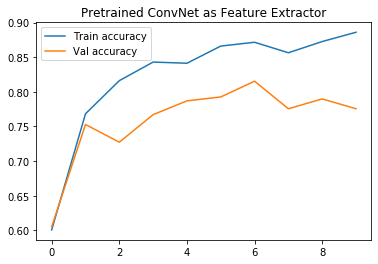

<Figure size 432x288 with 0 Axes>

In [32]:
# Display training curve 
display_training_curves(history, "Pretrained ConvNet as Feature Extractor")

### Fine tuning

##### Unfreeze top layers for fine tuning

In [0]:
# Unfreeze all layers in base model
base_model.trainable = True

In [34]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  155


In [0]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

##### Compile the model

In [0]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = Adam(1e-5),
              metrics=['accuracy'])

In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 165       
Total params: 2,626,821
Trainable params: 2,231,429
Non-trainable params: 395,392
_________________________________________________________________


##### Continue to train the model

In [0]:
INITIAL_EPOCHS = 10
FINE_TUNE_EPOCHS = 10
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS #20

In [39]:
%%time
history_fine = model.fit(train_batches,
                    epochs=TOTAL_EPOCHS,          #20
                    initial_epoch=INITIAL_EPOCHS, #10
                    validation_data=validation_batches,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)

Train for 91 steps, validate for 11 steps
Epoch 11/20
91/91 [==============================] - 17s 191ms/step - loss: 0.2834 - accuracy: 0.8949 - val_loss: 0.9009 - val_accuracy: 0.7812
Epoch 12/20
91/91 [==============================] - 11s 122ms/step - loss: 0.2292 - accuracy: 0.9146 - val_loss: 0.7421 - val_accuracy: 0.8239
Epoch 13/20
91/91 [==============================] - 14s 148ms/step - loss: 0.2292 - accuracy: 0.9122 - val_loss: 0.6486 - val_accuracy: 0.8438
Epoch 14/20
91/91 [==============================] - 12s 132ms/step - loss: 0.2049 - accuracy: 0.9260 - val_loss: 0.6151 - val_accuracy: 0.8523
Epoch 15/20
91/91 [==============================] - 14s 157ms/step - loss: 0.2085 - accuracy: 0.9239 - val_loss: 0.5820 - val_accuracy: 0.8636
Epoch 16/20
91/91 [==============================] - 14s 152ms/step - loss: 0.1891 - accuracy: 0.9301 - val_loss: 0.5821 - val_accuracy: 0.8580
Epoch 17/20
91/91 [==============================] - 12s 130ms/step - loss: 0.1744 - accuracy:

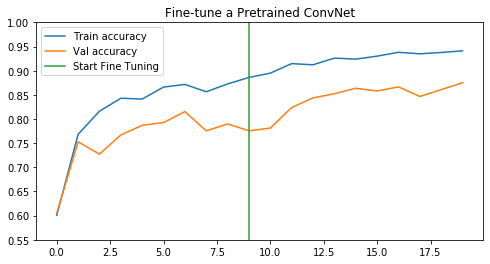

In [40]:
# Display training curve

acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

plt.figure(figsize=(8, 4))

plt.plot(acc, label='Train accuracy')
plt.plot(val_acc, label='Val accuracy')
plt.ylim([0.8, 1])
plt.plot([NUM_EPOCHS-1, NUM_EPOCHS-1], plt.ylim(ymin=0.55), label='Start Fine Tuning')
plt.title("Fine-tune a Pretrained ConvNet")
plt.legend(loc='upper left')

plt.show()

## Test accuracy

In [41]:
# Evaluate the model on the test dataset
score = model.evaluate(test_batches, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.83651227


## Visualize predictions

First we get images and labels from a test batch, and then use the retrained model to make predictions.

In [0]:
image_batch, label_batch = next(iter(test_batches))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_class_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_class_ids]

Then we visualize some of the images and compare whether the predicted labels equal to the true labels. 

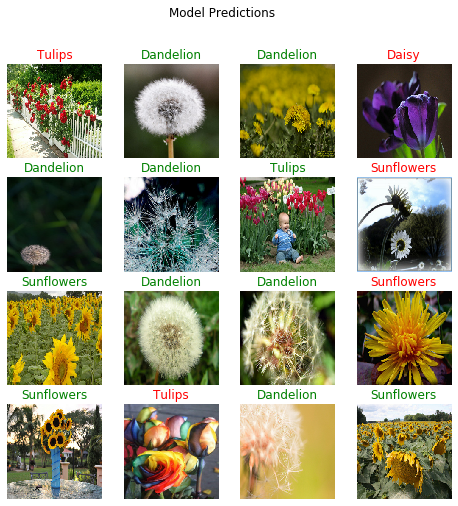

In [43]:
plt.figure(figsize=(8, 8))

# Display 16 test images with predictions
for i in range(16):
  plt.subplot(4, 4, i+1)
  # Display each image
  plt.imshow(image_batch[i])
  # Set title color: green if prediction correct and red if prediction incorrect
  title_color = "green" if predicted_class_ids[i] == label_batch[i] else "red"
  plt.title(predicted_class_names[i].title(), color=title_color)
  plt.axis('off')

_ = plt.suptitle("Model Predictions")